In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
%run setup.py
%matplotlib inline
sns.set(style='darkgrid')

In [2]:
def simulate_tag(params, start_date, end_date):
    """
    Simulates Ornstein-Uhlenbeck process following 
    dx_t = kappa * (mu - x_t) dt + sigma * dW_t
    """
    x0 = params['x0']
    kappa = params['kappa']
    sigma = params['sigma']
    mu = params['mu']
    
    time_grid = pd.date_range(start=start_date, end=end_date, freq='D').to_pydatetime()
    
    M = len(time_grid)
    path = np.zeros(M)
    path[0] = x0
    rand = np.random.standard_normal(M-1)
    day_count = 365
    dt = 1 / day_count
        
    for t in range(1, len(time_grid)):
        path[t] = path[t-1] + kappa * (mu - path[t-1]) * dt \
                + sigma * np.sqrt(dt) * rand[t - 1]
    return pd.DataFrame(path, time_grid, columns=['fake_ts1'])  

In [3]:
exps = ['Permute=False_Tag=False',
       'Permute=False_Tag=True',
       'Permute=True_Tag=False',
       'Permute=True_Tag=True']
df_res = pd.DataFrame(columns=exps, index=['LR', 'ANN'])

In [4]:
df = pd.read_csv(data_dir + 'owid-covid-data.csv',
    usecols=['date', 'iso_code', 'continent', 'location','new_cases_per_million','new_deaths_per_million'],
    parse_dates=['date']
)
df = df.dropna()


In [5]:
# List of EU countries
european_union = [
    'Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 
    'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']
df = df.loc[df.location.isin(european_union)]
num_nations = len(df.location.unique())
# we calculate various previous days' average.
df = df.set_index('date')
cols = ['new_cases_per_million', 'new_deaths_per_million']
temp = []
for c in cols:
    for d in [7, 14, 21, 28]:
        aux = df.groupby('iso_code')[c].rolling(f'{d}D', closed='left').mean()
        aux.name = f'{d}day_mean_{c}'
        temp.append(aux)
df = df.reset_index().set_index(['iso_code', 'date']).join(temp).reset_index()
df = df.dropna()
print(f'The number of samples is {df.shape[0]}')

The number of samples is 16517


<AxesSubplot:>

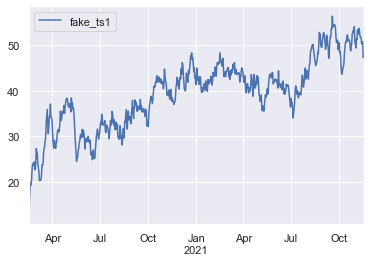

In [6]:
np.random.seed(143452)
tagparams = {
    'x0': 13,
    'kappa': 1,
    'sigma': 25,
    'mu': 15
}
fake_ts = simulate_tag(tagparams, start_date=df.date.min(), end_date=df.date.max())
df = df.join(fake_ts, on='date')
fake_ts.plot()

In [7]:
def adjusted_r_square(model, X, y):
    # Calculate adjusted R^2
    return 1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)
feature_set = [
    '14day_mean_new_cases_per_million', 
    '7day_mean_new_deaths_per_million']
y = df[['new_deaths_per_million']]
for i in range(1, len(feature_set) + 1):
    X = df[feature_set[:i]]
    model = LinearRegression().fit(X, y)
    print(f'Use {i} feastures, adjusted R2 is {adjusted_r_square(model, X, y): .2}')

Use 1 feastures, adjusted R2 is  0.41
Use 2 feastures, adjusted R2 is  0.76


In [8]:
X = df[feature_set + ['fake_ts1']]
y = df[['new_deaths_per_million']]
seven_mean = df['7day_mean_new_deaths_per_million']
num_features = len(feature_set)

In [9]:
def fit_evaluate_lr(X_train, y_train, X_test, y_test):
    model = LinearRegression(fit_intercept=True).fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    return mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)

def fit_evaluate_ann(X_train, y_train, X_test, y_test, l2_alpha=1e-3, filepath=None):
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    input_shape = (X_train.shape[1], )
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(5, input_shape=input_shape, 
                                 kernel_regularizer=keras.regularizers.L2(l2_alpha)))
    model.add(keras.layers.Dense(5, kernel_regularizer=keras.regularizers.L2(l2_alpha)))
    model.add(keras.layers.Dense(1))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse')
    model.fit(x=X_train, y=y_train, epochs=100)
    model.save(filepath)
    return model.evaluate(X_train, y_train), model.evaluate(x=X_test, y=y_test)

def load_evaluate_ann(X_train, y_train, X_test, y_test, filepath=None, l2_alpha=None):
    model = keras.models.load_model(filepath)
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return model.evaluate(X_train, y_train), model.evaluate(X_test, y_test)

ann_func = fit_evaluate_ann if TRAIN_BY_YOURSELF else load_evaluate_ann

#### Time split: We split each series in time to make train/test sets in the baseline experiment
**Chronological split experiment, i.e. Permute=False, Tag=False**

Dates before July-16-2021 become the training set, and the rest test set, leading to about a 8:2 ratio.

In [10]:
bl_train = (df['date'] < '2021-07-16').values
X_train = X.iloc[bl_train, :num_features]
y_train = y.loc[bl_train]
X_test = X.iloc[~bl_train, :num_features]
y_test = y.loc[~bl_train]

ckp_path = ckp_dir + 'Permute=False_Tag=False/model.h5'
lr_res = fit_evaluate_lr(X_train, y_train, X_test, y_test)
ann_res = ann_func(X_train, y_train, X_test, y_test, l2_alpha=1e-6, filepath=ckp_path)
baseline_benchmark = mean_squared_error(seven_mean.loc[~bl_train], y_test)
df_res.loc['LR', exps[0]] = (lr_res[1] - baseline_benchmark) / baseline_benchmark * 100
df_res.loc['ANN', exps[0]] = (ann_res[1] - baseline_benchmark) / baseline_benchmark * 100

106/106 [==============================] - 0s 513us/step - loss: 4.2183


**Chronological split with tagging, i.e. Permute=True, Tag=False**

Using the same chronological split to create the training and test set. The regression models now fit with an extra preditor simulated from an Ornstein–Uhlenbeck process.

In [11]:
X_train = X.loc[bl_train]
y_train = y.loc[bl_train]
X_test = X.loc[~bl_train]
y_test = y.loc[~bl_train]

ckp_path = ckp_dir + 'Permute=False_Tag=True/model.h5'
lr_res = fit_evaluate_lr(X_train, y_train, X_test, y_test)
ann_res = ann_func(X_train, y_train, X_test, y_test, l2_alpha=1e-6, filepath=ckp_path)
tag_benchmark = mean_squared_error(seven_mean.loc[~bl_train], y_test)
df_res.loc['LR', exps[1]] = (lr_res[1] - tag_benchmark) / tag_benchmark * 100
df_res.loc['ANN', exps[1]] = (ann_res[1] - tag_benchmark) / tag_benchmark * 100

106/106 [==============================] - 0s 617us/step - loss: 4.2893


**Random split, i.e. Permute=True, Tag=False**

In this experiment, we randomly split the training and test set independently for ten times. The split ratio is about 8:2.

In [12]:
num_iters = 10
test_size = X_test.shape[0] / df.shape[0]
print(f'{test_size * 100: .2f}% will be assigned to test set.')
X_train_set, X_test_set, y_train_set, y_test_set, seven_mean_train_set, seven_mean_test_set = [[] for _ in range(6)]

for i in range(num_iters):
    X_train, X_test, y_train, y_test, seven_train, seven_test = train_test_split(X, y, seven_mean, test_size=test_size, random_state=i)
    X_train_set.append(X_train)
    X_test_set.append(X_test)
    y_train_set.append(y_train)
    y_test_set.append(y_test)
    seven_mean_train_set.append(seven_train)
    seven_mean_test_set.append(seven_test)


 20.43% will be assigned to test set.


In [13]:
lr_train_mses, lr_test_mses, permute_benchmark_mses = [np.zeros((num_iters)) for _ in range(3)]
for i in range(num_iters):
    lr_train_mses[i], lr_test_mses[i] = fit_evaluate_lr(X_train_set[i].iloc[:, :num_features], y_train_set[i], X_test_set[i].iloc[:, :num_features], y_test_set[i])
    permute_benchmark_mses[i] = mean_squared_error(seven_mean_test_set[i], y_test_set[i])
    
ann_train_mses, ann_test_mses = [np.zeros((num_iters)) for _ in range(2)]
for i in range(num_iters):
    ckp_path = ckp_dir + f'Permute=True_Tag=False/model{i}.h5'
    ann_train_mses[i], ann_test_mses[i] = ann_func(X_train_set[i].iloc[:, :num_features], y_train_set[i], X_test_set[i].iloc[:, :num_features], y_test_set[i], l2_alpha=1e-5, filepath=ckp_path)

106/106 [==============================] - 0s 494us/step - loss: 6.1187


In [14]:
df_res.loc['LR', exps[2]] = (lr_test_mses.mean() - permute_benchmark_mses.mean()) / permute_benchmark_mses.mean() * 100
df_res.loc['ANN', exps[2]] = (ann_test_mses.mean() - permute_benchmark_mses.mean()) / permute_benchmark_mses.mean() * 100
rela_diff_permute = pd.DataFrame(index=['LR', 'ANN'], columns=range(num_iters))
rela_diff_permute.loc['LR'] = ((lr_test_mses - permute_benchmark_mses) / permute_benchmark_mses * 100 - df_res.loc['LR', exps[0]]) 
rela_diff_permute.loc['ANN'] = ((ann_test_mses - permute_benchmark_mses) / permute_benchmark_mses * 100 - df_res.loc['LR', exps[0]])

**Random split and tagging**

In addition to random split, we also tag each sample with a new simulated time series.

In [15]:
lr_train_mses, lr_test_mses = [np.zeros((num_iters)) for _ in range(2)]
for i in range(num_iters):
    lr_train_mses[i], lr_test_mses[i] = fit_evaluate_lr(X_train_set[i], y_train_set[i], X_test_set[i], y_test_set[i])

ann_train_mses, ann_test_mses = [np.zeros((num_iters)) for _ in range(2)]
for i in range(num_iters):
    ckp_path = ckp_dir + f'Permute=True_Tag=True/model{i}.h5'
    ann_train_mses[i], ann_test_mses[i] = ann_func(X_train_set[i], y_train_set[i], X_test_set[i], y_test_set[i], l2_alpha=1e-6, filepath=ckp_path)

106/106 [==============================] - 0s 522us/step - loss: 6.1215


In [16]:
df_res.loc['LR', exps[3]] = (lr_test_mses.mean() - permute_benchmark_mses.mean()) / permute_benchmark_mses.mean() * 100
df_res.loc['ANN', exps[3]] = (ann_test_mses.mean() - permute_benchmark_mses.mean()) / permute_benchmark_mses.mean() * 100
rela_diff_permute_vix = pd.DataFrame(index=['LR', 'ANN'], columns=range(num_iters))
rela_diff_permute_vix.loc['LR'] = ((lr_test_mses - permute_benchmark_mses) / permute_benchmark_mses * 100 - df_res.loc['LR', exps[0]]) 
rela_diff_permute_vix.loc['ANN'] = ((ann_test_mses - permute_benchmark_mses) / permute_benchmark_mses * 100 - df_res.loc['LR', exps[0]])

In [17]:
df_res

,Permute=False_Tag=False,Permute=False_Tag=True,Permute=True_Tag=False,Permute=True_Tag=True
LR,0.509753,1.711648,-1.618625,-1.662117
ANN,0.556686,2.248939,-1.62285,-1.687346


**Plotting**

The first one plots the relative reduciton of regressions to 7-day average benchmark in all four experiments. The second plots the difference in relative reduction of regressions performance in the 'Permute' and 'Permute + Tag' to baseline experiment.

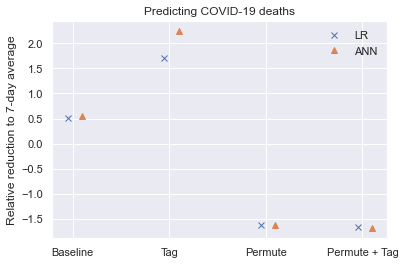

In [18]:
plot_kws = [('LR', 'x', -0.05, sns.color_palette()[0]),
       ('ANN', '^', 0.1, sns.color_palette()[1])]
for row in plot_kws:
    plt.plot(np.arange(1, 5)+row[2], df_res.loc[row[0]], marker=row[1], linewidth=0, label=row[0], c=row[3])
plt.legend(frameon=False)
plt.xticks(np.arange(1, 5), ('Baseline', 'Tag', 'Permute', 'Permute + Tag'))
plt.ylabel('Relative reduction to 7-day average')
plt.title('Predicting COVID-19 deaths')
plt.savefig(res_dir + 'Figure3_left.png', dpi=100)

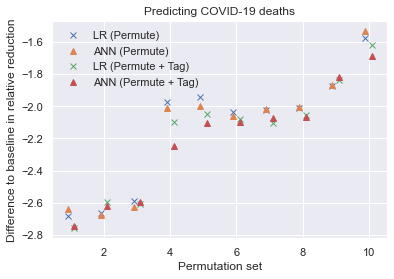

In [19]:
indices = rela_diff_permute_vix.T.sort_values('ANN').index
plot_kws = [('LR', 'x', -0.1, 'LR (Permute)'), ('ANN', '^', -0.1, 'ANN (Permute)')]
for row in plot_kws:
    plt.plot(np.arange(1, 1+num_iters)+row[2], rela_diff_permute.loc[row[0], indices], marker=row[1], linewidth=0, label=row[3])
plot_kws = [('LR', 'x', 0.1, 'LR (Permute + Tag)'), ('ANN', '^', 0.1, 'ANN (Permute + Tag)')]
for row in plot_kws:
    plt.plot(np.arange(1, 1+num_iters)+row[2], rela_diff_permute_vix.loc[row[0], indices], marker=row[1], linewidth=0, label=row[3])
plt.legend(frameon=False)
plt.xlabel('Permutation set')
plt.ylabel('Difference to baseline in relative reduction')
plt.title('Predicting COVID-19 deaths')
plt.savefig(res_dir + 'Figure3_right.png', dpi=100)

In [20]:
df_res

,Permute=False_Tag=False,Permute=False_Tag=True,Permute=True_Tag=False,Permute=True_Tag=True
LR,0.509753,1.711648,-1.618625,-1.662117
ANN,0.556686,2.248939,-1.62285,-1.687346


### Space split: we split samples into train/test set by countries in the baseline experiment
In the following, we again conduct four experiments.

- Standard split by space: We randomly pick roughly 4/5 nations as the train set, and the rest as the test set. The sereis of a nation will be put all together into either train or test. This is in constrast to chornological split.
- Standard split and tag: We tag each nation with an integer, from 1, 2,.... The series of a nation share the same integer all the time.
- Random split: This is the same as before. We randomly split the samples (not nations or time) into train and test sets.
- Random and tag: We tag nations and random split.

The standard split needs to be done multiple times, since the total number of EU nations is just 27, causing too much variation. Each iteration has different samples in the train/test sets, so we use the average number of samples when randomly split the train/test sets in the third and fourth experiments.


In [ ]:
np.random.seed(66)
country_tag = pd.Series(dict(zip(european_union, np.arange(num_nations))), name='country_tag')
df = df.join(country_tag, on='location')

In [ ]:
# we delete the time series column, and add a new country tag; each country has a tag.
X = df[feature_set + ['country_tag']]
y = df[['new_deaths_per_million']]
seven_mean = df['7day_mean_new_deaths_per_million']
num_features = len(feature_set)

In [ ]:
num_iters = 10
X_train_set, X_test_set, y_train_set, y_test_set, seven_mean_train_set, seven_mean_test_set = [[] for _ in range(6)]
sum_num_tests = 0
for i in range(num_iters):
    train_countries, test_countries = train_test_split(european_union, test_size=0.2, random_state=i)
    bl_train = df.location.isin(train_countries).values
    sum_num_tests += (~bl_train).sum()
    X_train, y_train = X.iloc[bl_train], y.loc[bl_train]
    X_test, y_test = X.iloc[~bl_train], y.loc[~bl_train]
    seven_train, seven_test = seven_mean.loc[bl_train], seven_mean.loc[~bl_train]
    X_train_set.append(X_train)
    X_test_set.append(X_test)
    y_train_set.append(y_train)
    y_test_set.append(y_test)
    seven_mean_train_set.append(seven_train)
    seven_mean_test_set.append(seven_test)

In [ ]:
ann_func = fit_evaluate_ann
exps = ['Permute=False_Tag=False',
       'Permute=False_Tag=True',
       'Permute=True_Tag=False',
       'Permute=True_Tag=True']
df_res = pd.DataFrame(columns=exps, index=['LR', 'ANN'])

**Standard split by nations**

In [ ]:
lr_train_mses, lr_test_mses, benchmark_mses = [np.zeros((num_iters)) for _ in range(3)]
for i in range(num_iters):
    lr_train_mses[i], lr_test_mses[i] = fit_evaluate_lr(X_train_set[i].iloc[:, :num_features], y_train_set[i], X_test_set[i].iloc[:, :num_features], y_test_set[i])
    benchmark_mses[i] = mean_squared_error(seven_mean_test_set[i], y_test_set[i])
    
ann_train_mses, ann_test_mses = [np.zeros((num_iters)) for _ in range(2)]
for i in range(num_iters):
    ckp_path = ckp_dir + f'Space_Split/Permute=False_Tag=False/model{i}.h5'
    ann_train_mses[i], ann_test_mses[i] = ann_func(X_train_set[i].iloc[:, :num_features], y_train_set[i], X_test_set[i].iloc[:, :num_features], y_test_set[i], l2_alpha=1e-5, filepath=ckp_path)

In [ ]:
df_res.loc['LR', exps[0]] = (lr_test_mses.mean() - benchmark_mses.mean()) / benchmark_mses.mean() * 100
df_res.loc['ANN', exps[0]] = (ann_test_mses.mean() - benchmark_mses.mean()) / benchmark_mses.mean() * 100

In [ ]:
lr_train_mses, lr_test_mses, benchmark_mses = [np.zeros((num_iters)) for _ in range(3)]
for i in range(num_iters):
    lr_train_mses[i], lr_test_mses[i] = fit_evaluate_lr(X_train_set[i], y_train_set[i], X_test_set[i], y_test_set[i])
    benchmark_mses[i] = mean_squared_error(seven_mean_test_set[i], y_test_set[i])
    
ann_train_mses, ann_test_mses = [np.zeros((num_iters)) for _ in range(2)]
for i in range(num_iters):
    ckp_path = ckp_dir + f'Space_Split/Permute=False_Tag=True/model{i}.h5'
    ann_train_mses[i], ann_test_mses[i] = ann_func(X_train_set[i], y_train_set[i], X_test_set[i], y_test_set[i], l2_alpha=1e-5, filepath=ckp_path)

In [ ]:
df_res.loc['LR', exps[1]] = (lr_test_mses.mean() - benchmark_mses.mean()) / benchmark_mses.mean() * 100
df_res.loc['ANN', exps[1]] = (ann_test_mses.mean() - benchmark_mses.mean()) / benchmark_mses.mean() * 100

In [ ]:
df_res

**Random split**

This splits is almost same as before, except the number of samples in train/test should be the average of train/test in the standard split.

In [ ]:
X_train_set, X_test_set, y_train_set, y_test_set, seven_mean_train_set, seven_mean_test_set = [[] for _ in range(6)]

for i in range(num_iters):
    X_train, X_test, y_train, y_test, seven_train, seven_test = train_test_split(X, y, seven_mean, test_size=int(sum_num_tests/num_iters), random_state=i)
    X_train_set.append(X_train)
    X_test_set.append(X_test)
    y_train_set.append(y_train)
    y_test_set.append(y_test)
    seven_mean_train_set.append(seven_train)
    seven_mean_test_set.append(seven_test)

In [ ]:
def run_lr_ann_loop(X_train_set, y_train_set, X_test_set, y_test_set, num_features, ann_ckp_dir, l2_alpha):
    num_iters = len(X_train_set)
    lr_train_mses, lr_test_mses, benchmark_mses = [np.zeros((num_iters)) for _ in range(3)]
    for i in range(num_iters):
        lr_train_mses[i], lr_test_mses[i] = fit_evaluate_lr(X_train_set[i].iloc[:, :num_features], y_train_set[i], X_test_set[i].iloc[:, :num_features], y_test_set[i])
        benchmark_mses[i] = mean_squared_error(seven_mean_test_set[i], y_test_set[i])
        
    ann_train_mses, ann_test_mses = [np.zeros((num_iters)) for _ in range(2)]
    for i in range(num_iters):
        ckp_path = ann_ckp_dir + 'model{i}.h5'
        ann_train_mses[i], ann_test_mses[i] = ann_func(X_train_set[i].iloc[:, :num_features], y_train_set[i], X_test_set[i].iloc[:, :num_features], y_test_set[i], l2_alpha=l2_alpha, filepath=ckp_path)
    return lr_test_mses, ann_test_mses, benchmark_mses

In [ ]:
ann_ckp_dir = ckp_dir + 'Permute=True_Tag=False'
lr_test_mses, ann_test_mses, benchmark_mses = run_lr_ann_loop(X_train_set, y_train_set, X_test_set, y_test_set, num_features, ann_ckp_dir, 1e-5)

In [ ]:
df_res.loc['LR', exps[2]] = (lr_test_mses.mean() - benchmark_mses.mean()) / benchmark_mses.mean() * 100
df_res.loc['ANN', exps[2]] = (ann_test_mses.mean() - benchmark_mses.mean()) / benchmark_mses.mean() * 100

In [ ]:
df_res

**Random and tag**

In [ ]:
ann_ckp_dir = ckp_dir + 'Permute=True_Tag=True'
lr_test_mses, ann_test_mses, benchmark_mses = run_lr_ann_loop(X_train_set, y_train_set, X_test_set, y_test_set, num_features+1, ann_ckp_dir, 1e-5)

In [ ]:
df_res.loc['LR', exps[3]] = (lr_test_mses.mean() - benchmark_mses.mean()) / benchmark_mses.mean() * 100
df_res.loc['ANN', exps[3]] = (ann_test_mses.mean() - benchmark_mses.mean()) / benchmark_mses.mean() * 100

In [ ]:
df_res